# 17. 7th Attempt: A2C

Advantage Actor Critic + Self-play learning 구현 (실패)

- Actor-Critic을 구현할 때 조심해야 하는 것 중 하나는 negative reward입니다.
보통은 큰 문제가 아닌데, learning rate가 작은 경우라면 몰라도,
어느 정도 커지게 되면 $\lambda A_t \log \pi$를 극대화하기 위해
미분인
$\lambda A_t \frac{1}{\pi}$를 따라 증가하게 되는데,
정책상 확률이 낮으면 $\frac{1}{\pi}$가 매우 커지게 되고,
$A_t$가 음수라서 확률이 매우 극단적으로 감소되게 됩니다. 이걸
반복하게 되면 특정 값이 음의 무한으로 발산하는 경우가 생기기도 합니다.
일단 Actor-Critic에서는 classification하듯이 cross entropy를
사용하다보니 BCE 같은 식의 loss를 쓰기도 그렇습니다.
- 결과적으로 이 방식이 오목에 대해서 학습 속도를 빠르게 하는 역할은
절대로 못 하는 듯 합니다.
- Self-play를 하고 싶다면 단순히 정책망만으로 탐색을 해서는
너무 느리며, MCTS를 넣는 방식으로 그 정책으로 할 수 있는 최선의
수를 선택하는 방법이 필요한 듯 합니다.
즉, 단순히 자기 자신이 두는 대로 두는 것을 반복하는 것이 아니라,
몇 수 뒤를 봐서 최대한 발악을 해보고, 그 경험을 신경망에
기록하는 방식으로 학습을 해야 발전이 있는 것 같습니다.


## Advantage Actor-Critic


### Environment

In [ ]:
!rm -rf *
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 1.83 MiB/s, done.
Resolving deltas: 100% (74/74), done.
Device: cuda


### Board Size

In [ ]:
# Board Size
W = 15
H = W

### Agent & Policy Transformer

In [ ]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)
  
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def softmax(arr, tau=1.0):
  arr = np.array(arr, dtype=np.float64)
  arr /= tau
  m = max(arr)
  z = np.exp(arr - m)
  return z / z.sum()

def pt_softmax(policy, tau=1.0):
  def p(game):
    p = policy(game)
    return softmax(p, tau=tau)
  p.name = 'pt_softmax({},tau={})'.format(fn_name(policy), tau)
  return p

def pt_norm(policy):
  def p(game):
    p = policy(game)
    return p / p.max()
  p.name = 'pt_norm({})'.format(fn_name(policy))
  return p

def policy_uniform(game):
  return np.ones(game.height * game.width)
policy_uniform.name = 'uniform'

In [ ]:
def test_agents(num_game, agent1, agent2):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    result = g.play(agent1, agent2,
                    print_intermediate_state=False, print_messages=False)
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  print("-- Test Result --")
  print("* Agent1 = {} \n* Agent2 = {}".format(
      fn_name(agent1), fn_name(agent2)))
  print("Total : {:5d}".format(num_game))
  print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
  print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))

In [ ]:
def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

### Neural Network

In [ ]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class FixedTempSoftmax(nn.Module):
  def __init__(self, dim, tau):
    super(FixedTempSoftmax, self).__init__()
    self.dim = dim
    self.tau = np.exp(tau)
  def forward(self, x):
    return nn.functional.softmax(x / self.tau, self.dim)

class TempSoftmax(nn.Module):
  def __init__(self, dim, tau=0):
    super(TempSoftmax, self).__init__()
    self.dim = dim
    self.tau = nn.Parameter(torch.tensor([tau], dtype=torch.float))
  def forward(self, x):
    return nn.functional.softmax(x / torch.exp(self.tau), self.dim)

In [ ]:
## nn
class ActorCritic(nn.Module):
  def __init__(self):
    super().__init__()
    # back
    self.decoder = nn.Sequential(
      nn.Conv2d(3, 128, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(128, 64, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(64, 32, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(32, 32, 3, padding='same'),
      nn.GELU()
    )
    # pi
    self.actor = nn.Sequential(
      nn.Conv2d(32, 16, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(16, 16, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(16, 1, 5, padding='same'),
      Flatten()
    )
    # v
    self.critic = nn.Sequential(
      nn.Conv2d(32, 16, 3, padding='same'),
      nn.GELU(),
      nn.Conv2d(16, 1, 5, padding='same'),
      nn.MaxPool2d((H, W)),
      Flatten(),
      nn.Tanh()
    )
    
    for layer in self.decoder:
      if hasattr(layer, 'weight'):
        nn.init.normal_(layer.weight, mean=0, std=0.01)
    for layer in self.actor:
      if hasattr(layer, 'weight'):
        nn.init.normal_(layer.weight, mean=0, std=0.01)
    for layer in self.critic:
      if hasattr(layer, 'weight'):
        nn.init.normal_(layer.weight, mean=0, std=0.01)

  def forward(self, x):
    y = self.decoder(x)
    p = self.actor(y)
    v = self.critic(y)
    return p, v

def init_nn():
  global model, model_backs
  model = ActorCritic().to(device)
  model_backs = []
  save_policy()

def save_policy():
  global model_backs
  n = ActorCritic()
  n.load_state_dict(model.state_dict())
  model_backs = (model_backs + [n])[-10: ]

In [ ]:
def policy_model(net):
  def c(game):
    X = game.tensor(dtype=torch.float).unsqueeze(dim=0).to(device)
    with torch.no_grad(): p, v = net(X)
    p = p.squeeze()
    mask = torch.zeros(p.shape, dtype=torch.float)
    for i in range(H * W):
      if game.board[i] != 0: mask[i] = -torch.inf
    p += mask.to(device)
    p = nn.functional.softmax(p, dim=-1)
    return p.cpu().numpy()
  c.name = 'model({:x})'.format(id(net))
  return c

In [ ]:
class Stat:
  def __init__(self, n=0, w=0, l=0, d=0): self.n, self.w, self.l, self.d = n, w, l, d
  def dup(self):
    return Stat(self.n, self.w, self.l, self.d)
  def __sub__(self, other):
    return Stat(self.n - other.n, self.w - other.w, self.l - other.l, self.d - other.d)
  def win(self):
    self.n += 1
    self.w += 1
  def lose(self):
    self.n += 1
    self.l += 1
  def draw(self):
    self.n += 1
    self.d += 1
  def update_by_result(self, result):
    self.n += 1
    if result == 1: self.w += 1
    elif result > 1: self.l += 1
    else: self.d += 1
  def win_rate(self):
    if self.n >= 1: return (self.w + 0.5 * self.d) / self.n
    else: return np.nan

In [ ]:
# REINFORCE
def learn(
    opt,
    n_episode,
    max_batch_size,
    gamma,
    interval_stat
):
  last_stat_epi = 0
  loss_acc = 0
  for epi in range(n_episode):
    # Generate episode
    result = 0
    Ps, Vs = [], []
    game = Mock5(H, W)
    while 1:
      result = game.check_win()
      if result is not None: break
      X = game.tensor(dtype=torch.float).unsqueeze(dim=0)
      X += torch.rand(X.shape) * 0.01 - 0.005
      p, v = model(X.to(device))
      p = p.squeeze()
      mask = torch.zeros(p.shape, dtype=torch.float)
      for i in range(H * W):
        if game.board[i] != 0: mask[i] = -torch.inf
      p += mask.to(device)
      p = nn.functional.softmax(p, dim=-1)
      pp = p.cpu().detach().numpy()
      s = pp.sum()
      if s <= 0:
        print("p", p)
        print("pp", pp)
        raise ValueError()
      else: idx = np.random.choice(H * W, p=(pp / s))
      Ps.append(p[idx])
      Vs.append(v.squeeze())
      game.place_stone_at_index(idx)
    Vs.append(torch.tensor(0.0 if result == 0 else -1.0).to(device))
    # Tensor-fy
    V0 = torch.stack(Vs[:-1]).to(device)
    V1 = torch.stack(Vs[1:]).detach().to(device)
    Q = - gamma * V1
    # Calculate Adv
    A = Q - V0.detach()
    for i in range(len(Ps)):
      if Ps[i] < 0.5:
        Ps[i] = 1 - Ps[i]
        A[i] = -A[i]
    P = torch.stack(Ps).to(device)
    log_prob = -torch.log(P)
    loss_pi = (A * log_prob).mean()
    loss_v = (Q - V0).pow(2).mean()
    loss = loss_pi + loss_v
    #print("Ep {}: pi {} v {}".format(epi, loss_pi, loss_v))
    # Learn
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_acc += loss.item()
    # Print status and evaluate
    if epi - last_stat_epi >= interval_stat:
      #save_policy()
      print("----------")
      print("Ep #{:<6d} Loss Change Accum {:13.10f}".format(
        epi, loss_acc / (epi - last_stat_epi)))
      print(game)
      test_a = agent(policy_model(model))
      #test_agents(10, test_a, m5rand.agent)
      #test_agents(10, test_a, m5pt.agent)
      last_stat_epi = epi
      loss_acc = 0

### Learning

In [ ]:
def run():
  init_nn()

  opt = optim.Adam(model.parameters(),
                  lr=1e-4,
                  weight_decay=1e-4)
  
  learn(
      opt = opt,
      n_episode = 15000,
      gamma = 0.99,
      max_batch_size = 32,
      interval_stat = 50)

run()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
D | . . X . . . X O X O X O . X O
E | X O . . . . O . X O O X X O X
----------
Ep #200    Loss Change Accum  0.0093862759
 [ Turn 106 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | X . . O . O X X X X O . . . .
1 | O . O . X X O O X O . . O . .
2 | . . X . . O . . . X . X X . .
3 | X X . . O X O . . O O X X . X
4 | . X . X . X . . . O . . . O .
5 | . X X O X . . X O O . X . . .
6 | . . O . . . X . . . O . . . .
7 | X . . O . . X X . . O X O . O
8 | X O O . X X . . O . O X . . X
9 | O X X . . . . . . . . O . . .
A | X O X . X X X . . O X O X . .
B | . O . X X . O . O X . . . O .
C | O O . . X O . . O . . O . . X
D | . O . . . X O . O . . O O . .
E | . X O . O O . . . X . . . O O
----------
Ep #250    Loss Change Accum  0.0093110850
 [ Turn  65 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | X . . . . . . . . . . . . . .
1 | . . . . . . . X . . . . . . .


## Evaluation


In [ ]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(40, agent(policy_model(policy)), a[i].agent)

 [ Turn  16 ; 1P's turn (tone = O) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E
--+------------------------------
0 | O . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . .
2 | O . . . . . . . . . . . . . .
3 | O . . . . . . . . . . . . . .
4 | X . . . . . . . . . . . . . .
5 | O . . . . . . . . . . . . . .
6 | O . . . . . . . . . . . . . .
7 | O X . X . . . . . . . . . . .
8 | O . . X . . . . . . . . . . .
9 | X . . X . . . . . . . . . . .
A | O . . X . . . . . . . . . . .
B | . . . X . . . . . . . . . . .
C | . . . . . . . . . . . . . . .
D | . . . . . . . . . . . . . . .
E | . . . . . . . . . . . . . . .
2p (agent-df) win!


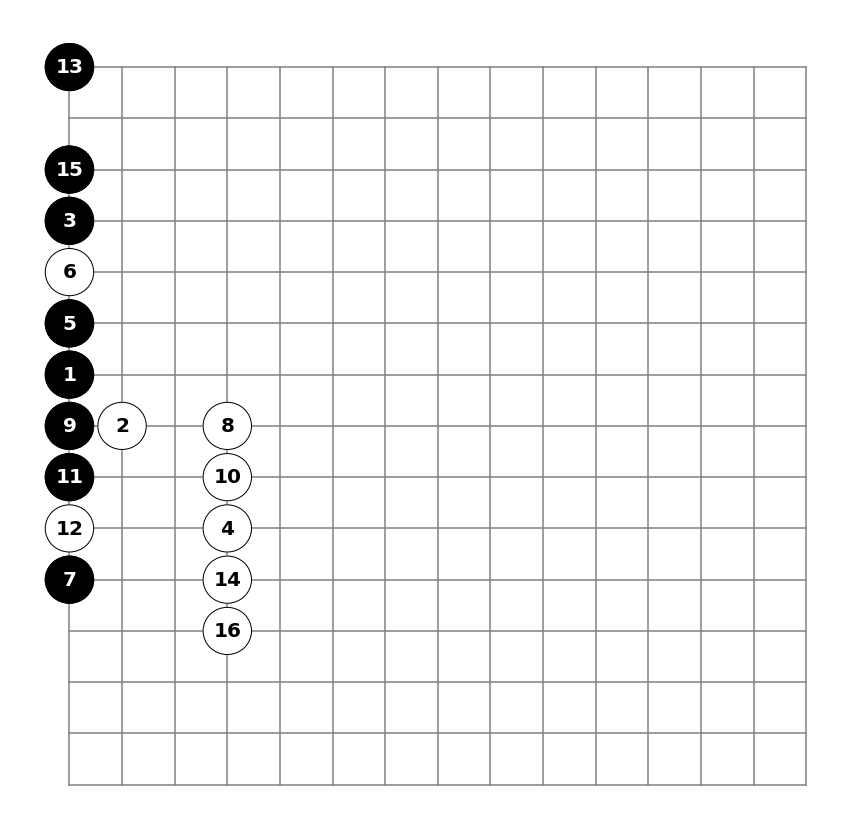

In [ ]:
m = Mock5(H, W)
m.play(agent(policy_model(model)), m5df.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

In [ ]:
p, v = model(Mock5().tensor().to(device))